<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Modified_Exercise_KNN_Breast_cancer_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXERCISE: KNN - Breast cancer dataset**

**Wisconsin Breast cancer dataset**

- In this exercise, we, as data scientists in the medical field, are asked to determine whether a tumor is malignant or benign.

- For simplicity, we will only use two features:
- Features: 'texture_mean' and 'concave points_mean'
- Target: 'diagnosis'



**Instruction**
- Create a new column derived from the diagnosis column. Convert it from a string to an integer:
  - malignant --> 1
  - benign --> 0

- Split the dataset using:
  - 20% test set
  - random_state = 42


- Model with KNN
  * Find the best K value for the KNN model, then use the accuracy metric to evaluate the model's performance between KNN without and with scaling (MinMaxScaler).

**Information related to the dataset can be found at the following link:**

<https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)>


In [ ]:
# importing required libraries

# data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# statistics
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# encoding
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import RobustScaler

# imputer
from sklearn.impute import KNNImputer

# column transformer (integrating preprocessing steps)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### **Data Understanding**

- The dataset describes 569 individuals.
- Each row represents information/characteristics of the texture_mean and concave point mean, along with diagnostic information.

In [ ]:
breast_cancer_wisconsin_csv = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/breast_cancer_wisconsin.csv'
data = pd.read_csv(breast_cancer_wisconsin_csv)
print(f'Number of rows and columns: {data.shape}')
data.head()

Number of rows and columns: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


For the purpose of this study, We will use only 2 features ('texture_mean', 'concave points_mean') and target ('diagnosis').

In [ ]:
data = data[['texture_mean', 'concave points_mean', 'diagnosis']]
data.head()

,texture_mean,concave points_mean,diagnosis
0,10.38,0.14710,M
1,17.77,0.07017,M
2,21.25,0.12790,M
3,20.38,0.10520,M
4,14.34,0.10430,M


**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
|texture_mean |Float | texture (standard deviation of gray-scale values) average |
|concave points_mean |Float | average of number of concave portions of the contour |
|diagnosis |Text | diagnosis result: M (Malignant) & B (Benign) |

**Initial Assesment**

In [ ]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,texture_mean,float64,0.0,False,479,"[10.38, 17.77, 21.25, 20.38, 14.34, 15.7, 19.9..."
1,concave points_mean,float64,0.0,False,542,"[0.1471, 0.07017, 0.1279, 0.1052, 0.1043, 0.08..."
2,diagnosis,object,0.0,False,2,"[M, B]"


**Descriptive Statistics**

In [ ]:
display(data.describe(), data.describe(include='object'))

,texture_mean,concave points_mean
count,569.000000,569.000000
mean,19.289649,0.048919
std,4.301036,0.038803
min,9.710000,0.000000
25%,16.170000,0.020310
50%,18.840000,0.033500
75%,21.800000,0.074000
max,39.280000,0.201200


,diagnosis
count,569
unique,2
top,B
freq,357


**Insight**

- The dataset consists of 569 rows and 3 columns.
- Numeric variables: texture_mean, concave points_mean
- Categorical variable: diagnosis
- Texture_mean ranges from 9.71 to 39.28
- Concave points_mean ranges from 0 to 0.2012

### **Exploratory Data Analysis (EDA)**

#### `Numerical Features`

**Data Distribution**

In [ ]:
numerical = [var for var in data.columns if data[var].dtypes != 'object']

In [ ]:
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())

    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"

    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,texture_mean,42.962593,4.685883e-10,Not Normally Distributed
1,concave points_mean,101.085836,1.120701e-22,Not Normally Distributed


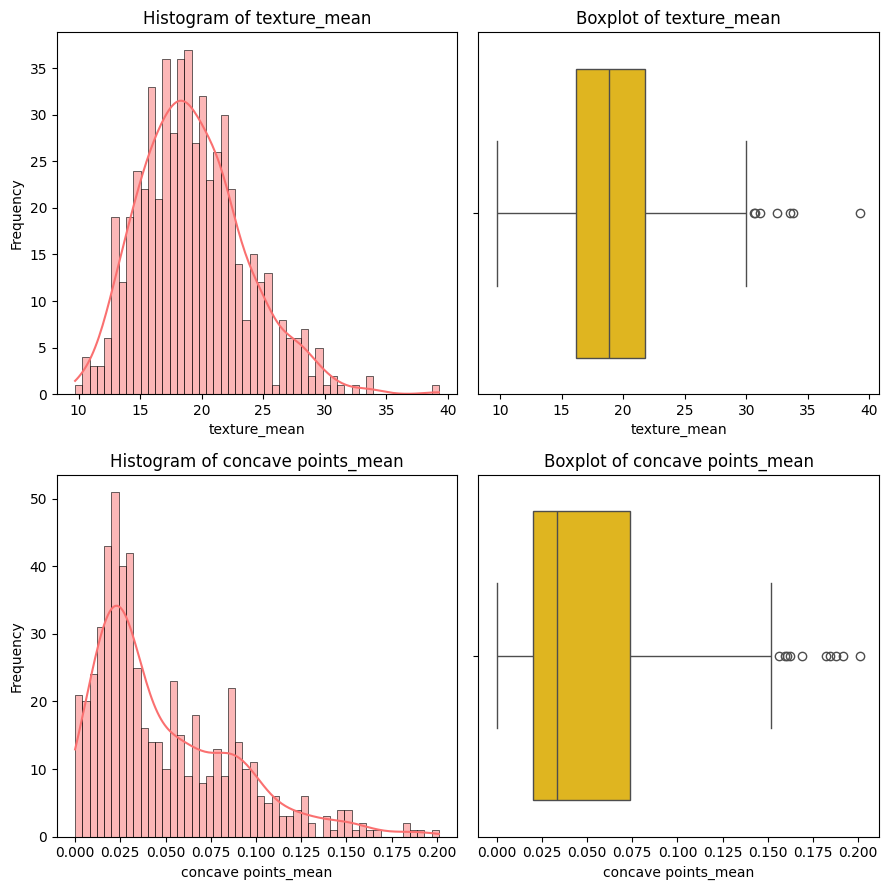

In [ ]:
plt.figure(figsize=(9, 9))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

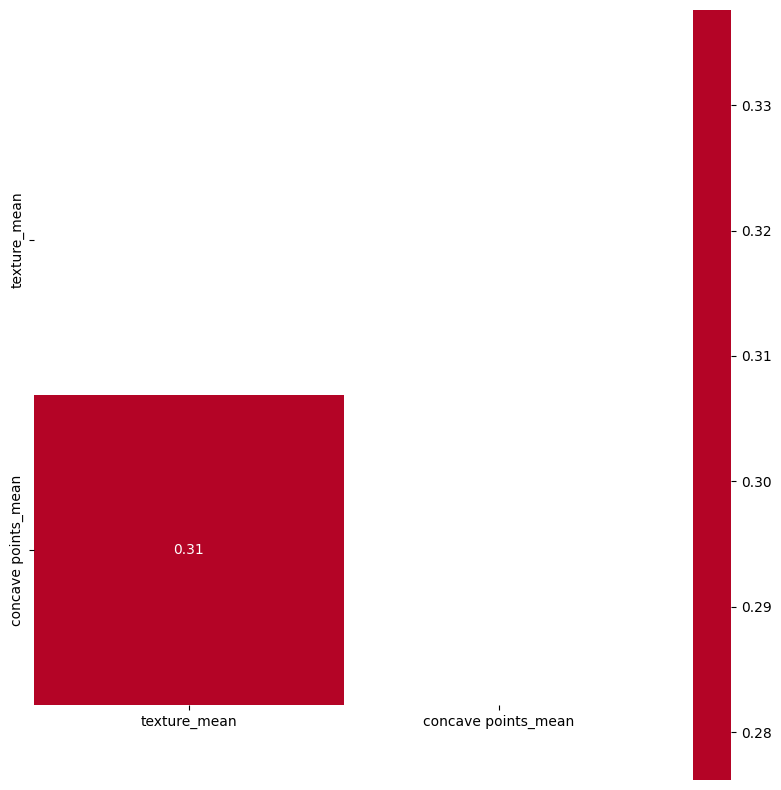

In [ ]:
plt.figure(figsize=(10,10))

matrix = np.triu(data.select_dtypes(include='number').corr(method='spearman'))

sns.heatmap(data=data.select_dtypes(include='number').corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

**Feature vs Target**

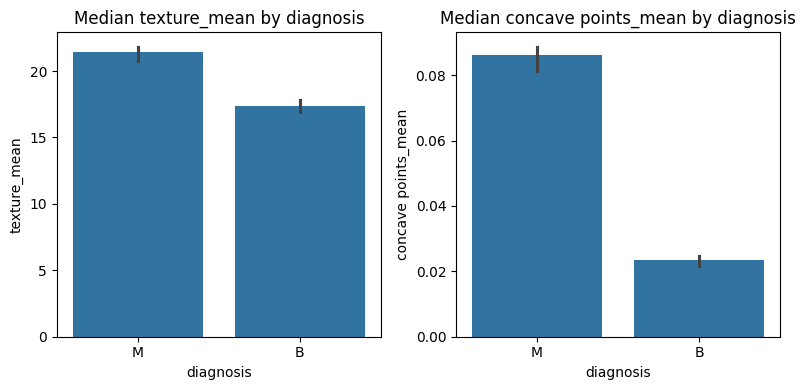

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

for col, j in zip(numerical, axes.flatten()):
    ax = sns.barplot(data=data, y= col, x='diagnosis', estimator=np.median, ax= j)
    ax.set_title(f'Median {col} by diagnosis')

plt.tight_layout()
plt.show()

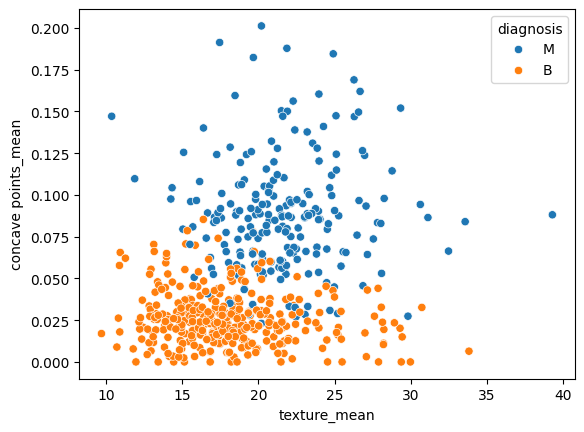

In [ ]:
sns.scatterplot(data=data, x='texture_mean', y='concave points_mean', hue='diagnosis')
plt.show()

### **Data Preprocessing**

#### `Duplicates`

In [ ]:
print(f"Number of duplicated data: {data[data.duplicated()].shape}")
print(f'Percentage of {len(data[data.duplicated()])/len(data)*100:.2f}%')

Number of duplicated data: (0, 3)
Percentage of 0.00%


There are no duplicates.

#### `Missing Values`

In [ ]:
pd.DataFrame({'missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,missing values
texture_mean,0
concave points_mean,0
diagnosis,0


There is no missing values

#### `Imbalance Data`

In [ ]:
# Check the class distribution
from collections import Counter

print("Class distribution:", Counter(data['diagnosis']))

Class distribution: Counter({'B': 357, 'M': 212})


In [ ]:
data['diagnosis'].value_counts(normalize=True)

,proportion
diagnosis,
B,0.627417
M,0.372583


The data can be categorized as moderate imbalance.

#### `Outliers`

In [ ]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,texture_mean,7,1.23,7.725000,30.245000
1,concave points_mean,10,1.76,-0.060225,0.154535


There are outliers in the numerical column with percentages ranging from 1.23% to 1.76%. We will examine the proportion of targets in these outliers.

In [ ]:
proportion = []
indeces = []

for i, row in outlier_df.iterrows():
    outlier = data[(data[row['Column']] < row['Lower Bound']) | (data[row['Column']] > row['Upper Bound'])]
    percentages = (outlier['diagnosis'].value_counts(normalize=True)*100).values
    proportion.append(percentages)
    indeces.append(row['Column'])

pd.DataFrame(proportion, columns=['Benign', 'Malignant'], index=indeces)

,Benign,Malignant
texture_mean,71.428571,28.571429
concave points_mean,100.000000,NaN


We find that the outliers in the 'texture_mean' and 'concave points_mean' columns have different proportions of 'Benign' and 'Malignant' items in the 'diagnosis' column compared to the rest of the data. Therefore, we will not remove these outliers because they contain information that impacts the target.

#### `Collinearity`

In [ ]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [ ]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [ ]:
vif_df

,Feature,VIF
0,texture_mean,2.836017
1,concave points_mean,2.836017


There is no multicollinearity

#### `Feature Engineering`

**Scaling**

We will use `MinMaxScaler`. We can reset the scaler later to get the best scaler.

**Change Value**

Let's first change the values ​​in the "diagnosis" column from "M" and "B" to 1 and 0. Since our primary focus is on those with high incomes, then:

Target:

0: Benign

1: Malignant

In [ ]:
data['diagnosis'] = np.where(data['diagnosis']=='M',1,0)
data['diagnosis'].unique()

array([1, 0])

### **Modeling**

**Define Features (X) and Target (y)**

In [ ]:
# feature
X = data.drop(columns='diagnosis')

# target
y = data['diagnosis']

**Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### `Model Experiment`

Setting basic parameters to initialize the experiment and create a transformation pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Create a Column Transformer
transformer = ColumnTransformer([
    ('scaler', MinMaxScaler(), ['texture_mean', 'concave points_mean'])
], remainder='passthrough')

# fit and transform your data using the preprocessor
X_train_scale = transformer.fit_transform(X_train)
X_test_scale = transformer.transform(X_test)

**Benchmark Model**

`Without Scaling`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the model
estimator = KNeighborsClassifier(metric="euclidean", n_neighbors=3)

# Fitting the model
estimator.fit(X_train, y_train)

# Predict
ypred_test = estimator.predict(X_test)

# Evaluate
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the test set: 0.7719298245614035


`With Scaling`

In [ ]:
# Define the model
estimator = KNeighborsClassifier(metric="euclidean", n_neighbors=3)

# Fitting the model
estimator.fit(X_train_scale, y_train)

# Predict
ypred_test = estimator.predict(transformer.transform(X_test))

# Evaluate
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the test set: 0.9210526315789473


The accuracy results using the KNN method increased after scaling for n_neighbors = 3.

- Without scaling: 77.2%
- With scaling: 92.1%

**Model Selection**

In [ ]:
# Declare a list to hold the result
training_accuracies = []
testing_accuracies = []

# Specify the number of k iterations
k = range(1, 50, 2)
best_accuracy = 0

for i in k:
    # Train the model
    estimator = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    estimator.fit(X_train_scale, y_train)

    # Predict on the training and testing data
    y_train_pred = estimator.predict(X_train_scale)
    y_test_pred = estimator.predict(X_test_scale)

    # Calculate the accuracies score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Append them to the lists
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)

    # Select k with the highest test accuracy score
    if best_accuracy < testing_accuracies[-1]:
        best_accuracy = testing_accuracies[-1]
        best_k = i
        best_estimator = estimator

# Compile the results into a dataframe
pd.DataFrame(
    {
        'K Nearest': [i for i in k],
        'Training': training_accuracies,
        'Testing': testing_accuracies,
    }
).sort_values(by=['Testing', 'Training'], ascending=False).head()


,K Nearest,Training,Testing
20,41,0.940659,0.947368
22,45,0.940659,0.947368
23,47,0.940659,0.947368
4,9,0.938462,0.947368
5,11,0.938462,0.947368


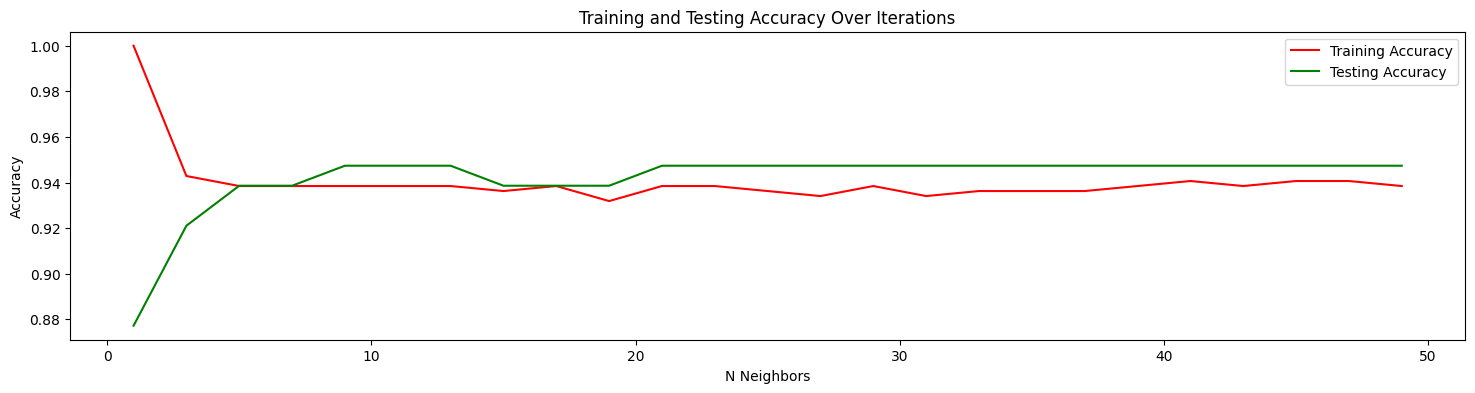

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and testing accuracies
plt.figure(figsize=(18,4))
plt.plot(k, training_accuracies, label="Training Accuracy", c='red')
plt.plot(k, testing_accuracies, label="Testing Accuracy", c='green')
plt.xlabel("N Neighbors")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy Over Iterations")
plt.legend()
plt.show()

the best k is probably around 7–12, with testing accuracy 0.95.

**Model Interpretation**

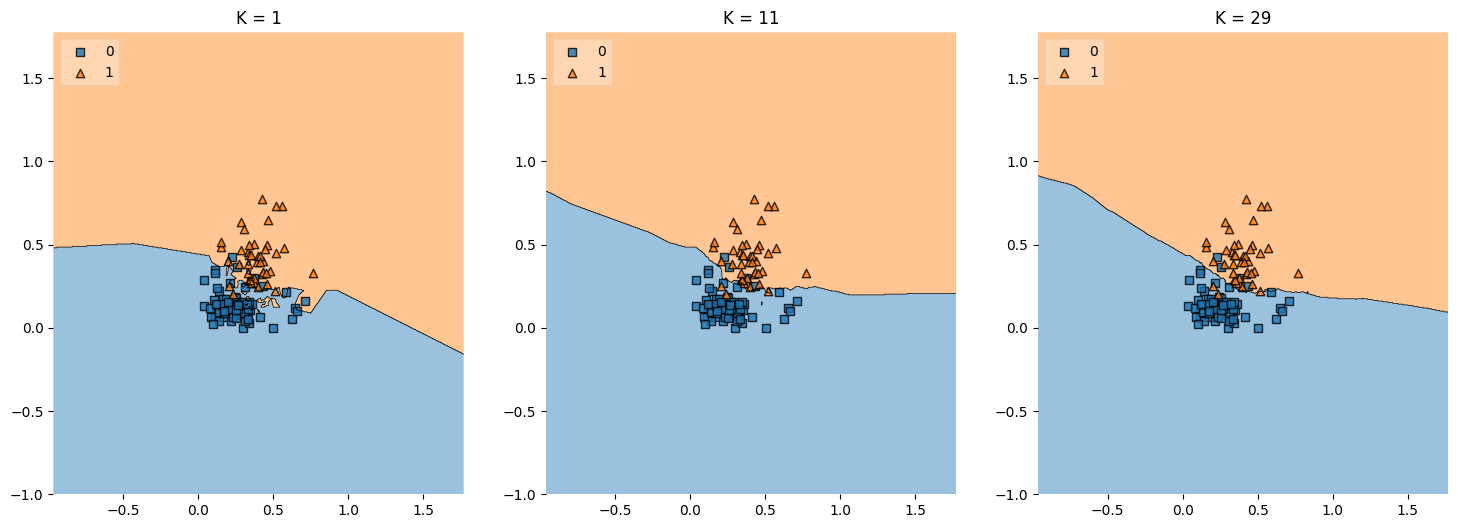

In [ ]:
from mlxtend.plotting import plot_decision_regions

# Assuming X has only two features
fig, ax = plt.subplots(1,3, figsize=(18,6))

for id, k in enumerate([1, 11, 29]):
    # Train the model
    estimator = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    estimator.fit(X_train_scale, y_train)

    # Set title
    ax[id].set_title(f'K = {k}')

    # Plot the decision boundaries
    plot_decision_regions(X_test_scale, y_test.to_numpy(), clf=estimator, legend=2, ax=ax[id])

# Show the plot
plt.show()

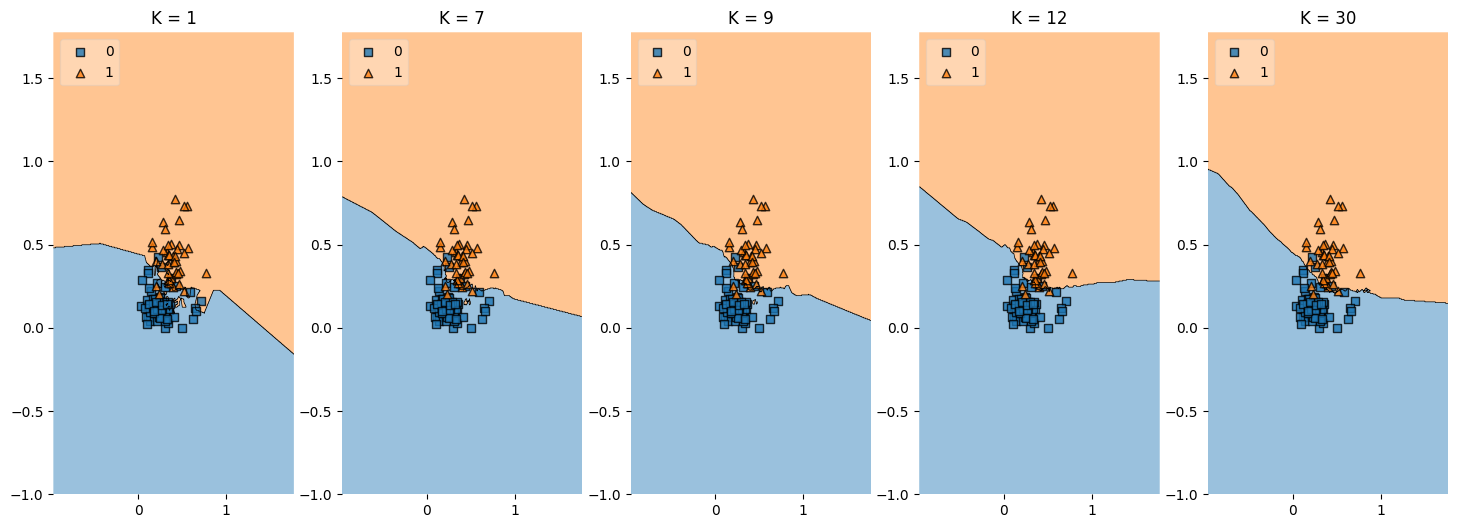

In [ ]:
from mlxtend.plotting import plot_decision_regions

# Assuming X has only two features
fig, ax = plt.subplots(1,5, figsize=(18,6))

for id, k in enumerate([1, 7, 9, 12, 30]):
    # Train the model
    estimator = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    estimator.fit(X_train_scale, y_train)

    # Set title
    ax[id].set_title(f'K = {k}')

    # Plot the decision boundaries
    plot_decision_regions(X_test_scale, y_test.to_numpy(), clf=estimator, legend=2, ax=ax[id])

# Show the plot
plt.show()

We can see large K values ​​cause the decision boundary to tend to be smoother and less sensitive to small variations in the data.

**Insights from Each K Value**

**K = 1**

* Decision boundary is very jagged and irregular.

* Model is highly sensitive to noise (overfitting).

* Every point decides its own boundary → good training accuracy, but poor generalization.

**K = 7**

* Boundaries are smoother compared to K=1.

* Better balance between bias and variance.

* The model captures general patterns while reducing noise influence.

**K = 9**

* Similar to K=7, boundaries remain smooth.

* Still able to separate benign (blue) and malignant (orange) fairly well.

* Likely close to an optimal K for this dataset. Aligns with the highest accuracy score.

**K = 12**

* Boundary gets smoother, but some detail is lost.

* May risk underfitting since smaller local variations are ignored.

* Still performs reasonably well but less flexible than K=7 or K=9.

**K = 30**

* Boundary is very smooth and almost linear.

* Model ignores local structure → high bias, low variance.

* Many malignant cases (orange) near benign regions may get misclassified.

* Clear sign of underfitting.


To sum up:
* Small K (like 1): Overfits → captures noise, poor generalization. The model reacts tp every tiny variation in patient data. A small error in measuring tumor size could flip a patient's prediction from benign to malignant. This may cause false alarms that ask for unnecessary biopsies or surgery.

* Moderate K (7–9): Best trade-off between bias and variance → good generalization. The models look relatively general that it can reduce noise influence (not that affected by outliers) and accurately avoiding unnecessary false positives.

* Large K (12–30): Too smooth, risks underfitting → may misclassify borderline cases. The models may misses some false negatives which is dangerous. Patients may get delayed diagnosis and cause them don't get early treatment.

For the Breast Cancer Wisconsin dataset, K between 7 and 9 seems to give the most reliable decision boundaries. It balances sensitivity (catching malignant cases) and specificity (correctly identifying benign cases) without overfitting.

Now, lets check the accuracy between models

**Final Model**

In [ ]:
# K = 7
estimator = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
estimator.fit(X_train_scale, y_train)

ypred_train = estimator.predict(X_train_scale)
ypred_test = estimator.predict(X_test_scale)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.9384615384615385
Model accuracy score in the test set: 0.9385964912280702


In [ ]:
# K = 9
estimator = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
estimator.fit(X_train_scale, y_train)

ypred_train = estimator.predict(X_train_scale)
ypred_test = estimator.predict(X_test_scale)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.9384615384615385
Model accuracy score in the test set: 0.9473684210526315


In [ ]:
# K = 30
estimator = KNeighborsClassifier(n_neighbors=30, metric='euclidean')
estimator.fit(X_train_scale, y_train)

ypred_train = estimator.predict(X_train_scale)
ypred_test = estimator.predict(X_test_scale)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.9362637362637363
Model accuracy score in the test set: 0.9473684210526315


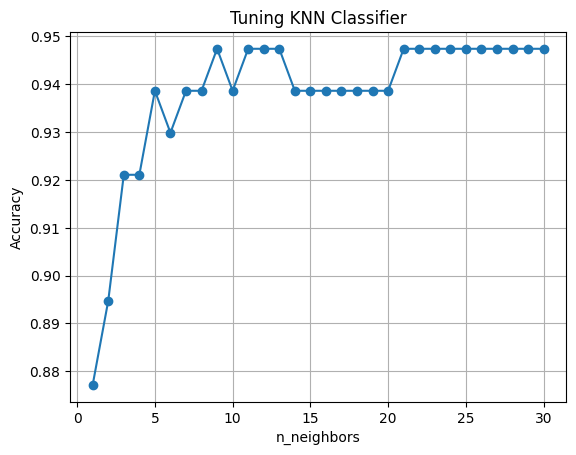

In [ ]:
# Tuning manual KNN Classifier # with scaling
accuracies = []
for k in range(1, 31):
    estimator = KNeighborsClassifier(n_neighbors=k)
    estimator.fit(X_train_scale, y_train)
    y_pred = estimator.predict(X_test_scale)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.plot(range(1, 31), accuracies, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Tuning KNN Classifier')
plt.grid(True)
plt.show()

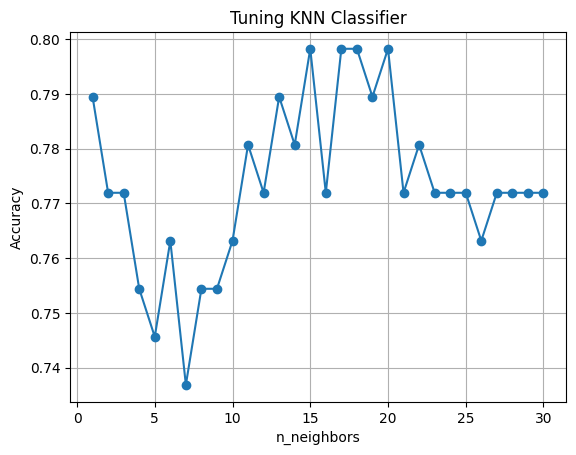

In [ ]:
# Tuning manual KNN Classifier # without scaling
accuracies = []
for k in range(1, 31):
    estimator = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.plot(range(1, 31), accuracies, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Tuning KNN Classifier')
plt.grid(True)
plt.show()

- Accuracy on our experiment, the best test set performance is 94.7% on K = 9 and K = 30
- The KNN model was able to correctly predict 94.7% of cancer diagnoses (both malignant and benign).
- Scaling helps in improving accuracy
- Of the 114 patients, 108 were correctly diagnosed.

**Predict to New Data**

We will use K = 9 for the prediction model as it seems the most optimal based on previous analysis.

In [ ]:
X.describe().loc[['min', 'max']]

,texture_mean,concave points_mean
min,9.71,0.0000
max,39.28,0.2012


In [ ]:
# Experiment with data
new_data = pd.DataFrame({
    'texture_mean' : [10, 20, 30, 35],
    'concave points_mean': [0.05, 0.1, 0.15, 0.2],
})

new_data

,texture_mean,concave points_mean
0,10,0.05
1,20,0.10
2,30,0.15
3,35,0.20


In [ ]:
# example of predicting new data
estimator.predict(transformer.transform(new_data)).round(2)

array([0, 1, 1, 1])

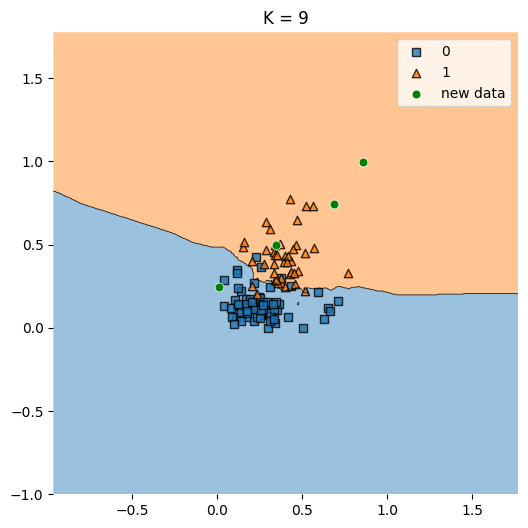

In [ ]:
# Assuming X has only two features
fig, ax = plt.subplots(figsize=(6,6))

# Train the model
estimator = KNeighborsClassifier(n_neighbors=11, metric="euclidean")
estimator.fit(X_train_scale, y_train)

# Set title
ax.set_title(f'K = 9')

# Plot the decision boundaries
ax = plot_decision_regions(X_test_scale, y_test.to_numpy(), clf=estimator, legend=2, ax=ax)

# Plot scatterplot
sns.scatterplot(x=transformer.transform(new_data)[:, 0], y=transformer.transform(new_data)[:, 1], color='green', label='new data', s=40)

# Show the plot
plt.show()